StepSense: Deep Learning Approach to Retail Footfall Forecasting Using GRU Networks

The objective of StepSense is to predict future retail footfall trends using historical time series data and advanced Recurrent Neural Networks (GRU). By analyzing patterns across dates, seasonal behaviors, and visitor fluctuations, StepSense aims to help retail stores, malls, and event spaces anticipate customer flow, optimize staffing, and enhance operational efficiency through accurate, data-driven forecasting.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [101]:
df = pd.read_csv("footfallhourly.csv", parse_dates=['Date'])
df.head()

,Id,Date,SiteName,LocationName,LocationGroup,WeekDay,BRCYear,BRCQuarter,BRCMonth,BRCWeek,InCount,OutCount,TotalCount,BusinessInCount,BusinessOutCount,BusinessTotalCount,FactoredInCount,FactoredOutCount,FactoredTotalCount
0,155258,2009-03-30 00:00:00,York,Coney Street,NaN,Monday,2009,NaN,March,13,213.0,NaN,213.0,NaN,NaN,NaN,NaN,NaN,NaN
1,155259,2009-03-30 01:00:00,York,Coney Street,NaN,Monday,2009,NaN,March,13,100.0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN
2,155262,2009-03-30 02:00:00,York,Coney Street,NaN,Monday,2009,NaN,March,13,321.0,NaN,321.0,NaN,NaN,NaN,NaN,NaN,NaN
3,155263,2009-03-30 03:00:00,York,Coney Street,NaN,Monday,2009,NaN,March,13,235.0,NaN,235.0,NaN,NaN,NaN,NaN,NaN,NaN
4,155266,2009-03-30 04:00:00,York,Coney Street,NaN,Monday,2009,NaN,March,13,47.0,NaN,47.0,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
df['Date'] = pd.to_datetime(df['Date'].astype(str))
df = df[['Date', 'LocationName', 'TotalCount']]

In [103]:
df.info()
df.dropna(subset=['TotalCount'],inplace=True)
location = "Coney Street"
df = df[df['LocationName'].str.contains(location, case=False, na=False)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429096 entries, 0 to 429095
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          429096 non-null  datetime64[ns]
 1   LocationName  429096 non-null  object        
 2   TotalCount    416812 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 9.8+ MB


In [104]:
df = df.sort_values('Date').reset_index(drop=True)
df.head()

,Date,LocationName,TotalCount
0,2009-03-30 00:00:00,Coney Street,213.0
1,2009-03-30 01:00:00,Coney Street,100.0
2,2009-03-30 02:00:00,Coney Street,321.0
3,2009-03-30 03:00:00,Coney Street,235.0
4,2009-03-30 04:00:00,Coney Street,47.0


In [105]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['TotalCount']].values)

Creating a Time Series Data:

TimeStep means the model looks at the past n time points to predict the next one.

In [106]:
def prepare_data(data, time_step=1):
    x, y = [], []
    for i in range(len(data)-time_step-1):
        x.append(data[i:(i+time_step),0])
        y.append(data[i+time_step,0])
    return np.array(x), np.array(y)

In [107]:
time_step = 24
x, y = prepare_data(scaled_data,time_step)
x = x.reshape(x.shape[0],x.shape[1],1)  #(samples, timesteps, features) this is required for GRU,LSTM etc

In [108]:
model = Sequential()

First Layer

In [109]:
model.add(GRU(units=50,return_sequences=True, input_shape = (x.shape[1],1)))
#This layer reads 100 past values (a sequence) and outputs a sequence of 50-dimensional hidden states.

Second Layer

In [110]:
model.add(GRU(units=50))
#After analyzing all 100 past values, here’s what I’ve understood

Output Layer: Dense

In [111]:
model.add(Dense(units=1))
#It takes the GRU’s output and produces 1 final number which is the predicted next value in your time series.

Compile all: Adam is an adaptive optimization algorithm that adjusts learning rate dynamically.

In [112]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

In [113]:
model.fit(x, y, epochs=6, batch_size=32) 
#epochs means iterations and in each iter, batch size denotes samples

Epoch 1/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 0.0011
Epoch 2/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 7.2330e-04
Epoch 3/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 6.8704e-04
Epoch 4/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 6.6943e-04
Epoch 5/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 50s 18ms/step - loss: 6.4494e-04
Epoch 6/6
2787/2787 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step - loss: 6.2177e-04


In [114]:
user_input = input("\nEnter a date & time (YYYY-MM-DD HH:MM): ")
user_dt = pd.to_datetime(user_input, errors='coerce')

if pd.isna(user_dt):
    print("⚠️ Invalid date format! Use YYYY-MM-DD HH:MM")
else:
    input_seq = scaled_data[-time_step:].reshape(1, time_step, 1)
    predicted_value = model.predict(input_seq)
    predicted_value = scaler.inverse_transform(predicted_value)

    print(f"\nLocation: {location}")
    print(f"Forecast for: {user_dt}")
    print(f"Predicted Footfall: {predicted_value[0][0]:.0f} people")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step

Location: Coney Street
Forecast for: 2025-07-22 17:23:00
Predicted Footfall: 96 people


2787/2787 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step


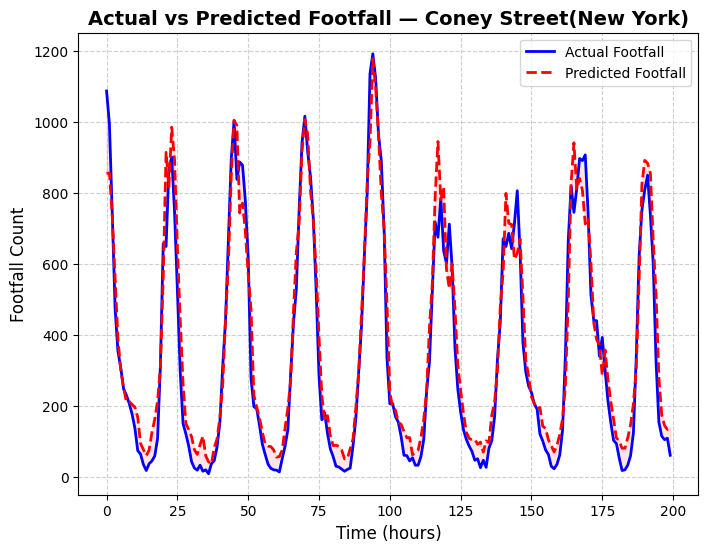

In [125]:
predicted_scaled = model.predict(x)
predicted_actual = scaler.inverse_transform(predicted_scaled)
actual_values = scaler.inverse_transform(y.reshape(-1, 1))

plt.figure(figsize=(8, 6))
plt.plot(actual_values[-200:], label='Actual Footfall', color='blue', linewidth=2)
plt.plot(predicted_actual[-200:], label='Predicted Footfall', color='red', linestyle='--', linewidth=2)
plt.fill_between(range(200), predicted_actual[-200:].flatten(), actual_values[-200:].flatten(), color='red', alpha=0.1)
plt.title(f"Actual vs Predicted Footfall — {location}(New York)", fontsize=14, fontweight='bold')
plt.xlabel("Time (hours)", fontsize=12)
plt.ylabel("Footfall Count", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


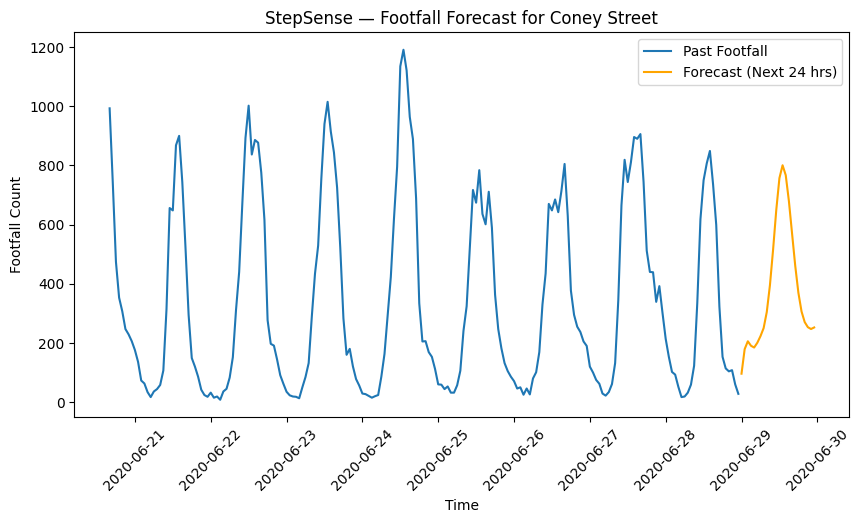

In [121]:
future_predictions = []
input_seq = scaled_data[-time_step:].reshape(1, time_step, 1)

for _ in range(24):  # Predict next 24 hours
    pred = model.predict(input_seq)
    future_predictions.append(pred[0][0])
    input_seq = np.append(input_seq[:, 1:, :], [[[pred[0][0]]]], axis=1)


future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['Date'].iloc[-200:], df['TotalCount'].iloc[-200:], label='Past Footfall')
future_dates = pd.date_range(df['Date'].iloc[-1], periods=25, freq='H')[1:]
plt.plot(future_dates, future_predictions, label='Forecast (Next 24 hrs)', color='orange')
plt.title(f"StepSense — Footfall Forecast for {location}")
plt.xlabel("Time")
plt.xticks(rotation=45)
plt.ylabel("Footfall Count")
plt.legend()
plt.show()


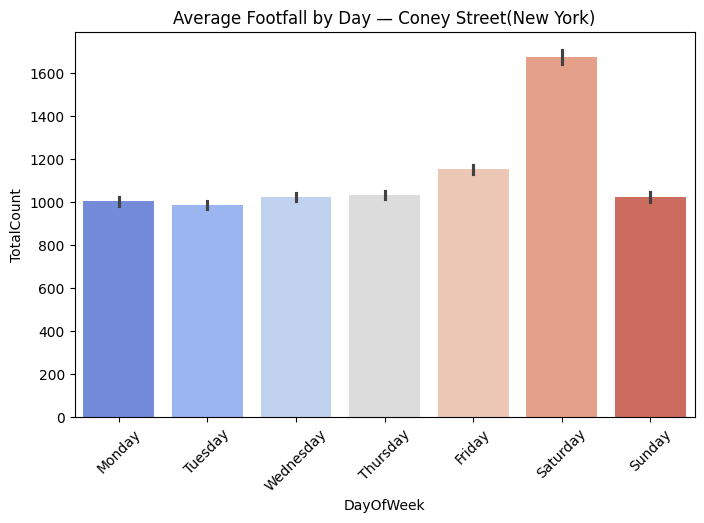

In [124]:
df['DayOfWeek'] = df['Date'].dt.day_name()
plt.figure(figsize=(8,5))
sns.barplot(x='DayOfWeek', y='TotalCount', data=df, order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], palette='coolwarm')
plt.title(f"Average Footfall by Day — {location}(New York)")
plt.xticks(rotation=45)
plt.show()
